In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import datetime
import seaborn as sns
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.options.display.max_columns = None

# Set your own project id here
PROJECT_ID = 'NYC-parking'
from google.cloud import bigquery
bigquery_client = bigquery.Client(project=PROJECT_ID)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv
/kaggle/input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2016.csv
/kaggle/input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2015.csv
/kaggle/input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv


In [16]:
names = [
        "summons_number", "plate_id", "registration_state", "plate_type",
        "issue_date", "violation_code", "vehicle_body_type", "vehicle_make", 
        "issuing_agency", "street_code1", "street_code2", "street_code3",
        "vehicle_expiration_date", "violation_location","violation_precinct",  "issuer_precinct",
        "issuer_code", "issuer_command", "issuer_squad", "violation_time",
        "time_first_observed", "violation_county", "violation_in_front_of_or_opposite",
        "house_number", "street_name", "intersecting_street", "date_first_observed",
        "law_section", "sub_division", "violation_legal_code", "days_parking_in_effect",
        "from_hours_in_effect", "to_hours_in_effect", "vehicle_color", "unregistered_vehicle",
        "vehicle_year", "meter_number", "feet_from_curb", "violation_post_code",
        "violation_description", "no_standing_or_stopping_violation", "hydrant_violation", "double_parking_violation"
]

dtype = {
        "violation_code": "str", "violation_location":"str"
}

data = pd.read_csv("../input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv", 
                   encoding='utf-8', names=names, skiprows=1, header=None, nrows=300000, dtype=dtype)


In [3]:
data.head(20)



,summons_number,plate_id,registration_state,plate_type,issue_date,violation_code,vehicle_body_type,vehicle_make,issuing_agency,street_code1,street_code2,street_code3,vehicle_expiration_date,violation_location,violation_precinct,issuer_precinct,issuer_code,issuer_command,issuer_squad,violation_time,time_first_observed,violation_county,violation_in_front_of_or_opposite,house_number,street_name,intersecting_street,date_first_observed,law_section,sub_division,violation_legal_code,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,unregistered_vehicle,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,no_standing_or_stopping_violation,hydrant_violation,double_parking_violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0143A,NaN,BX,NaN,NaN,ALLERTON AVE (W/B) @,BARNES AVE,0,1111,D,T,NaN,NaN,NaN,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0400P,NaN,BX,NaN,NaN,ALLERTON AVE (W/B) @,BARNES AVE,0,1111,D,T,NaN,NaN,NaN,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
2,4006265037,FZX9232,NY,PAS,08/23/2016,5,SUBN,FORD,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0233P,NaN,BX,NaN,NaN,SB WEBSTER AVE @ E 1,94TH ST,0,1111,C,T,NaN,NaN,NaN,BK,NaN,2004,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN
3,8478629828,66623ME,NY,COM,06/14/2017,47,REFG,MITSU,T,10610,34330,34350,20180630,0014,14,14,359594,T102,J,1120A,NaN,NY,O,330,7th Ave,NaN,0,408,l2,NaN,Y,0700A,0700P,WH,NaN,2007,NaN,0,04,47-Double PKG-Midtown,NaN,NaN,NaN
4,7868300310,37033JV,NY,COM,11/21/2016,69,DELV,INTER,T,10510,34310,34330,20170228,0013,13,13,364832,T102,M,0555P,NaN,NY,F,799,6th Ave,NaN,0,408,h1,NaN,Y,0700A,0700P,WHITE,NaN,2007,NaN,0,31 6,69-Failure to Disp Muni Recpt,NaN,NaN,NaN
5,5096917368,FZD8593,NY,PAS,06/13/2017,7,SUBN,ME/BE,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0852P,NaN,QN,NaN,NaN,NORTHERN BLVD (E/B),@ MARATHON PKWY,0,1111,D,T,NaN,NaN,NaN,WH,NaN,2012,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
6,1413609545,X20DCM,NJ,PAS,08/03/2016,40,SDN,TOYOT,P,54070,39430,54930,0,0071,71,71,960290,0071,0000,0215A,NaN,K,F,439,KINGSTON,NaN,0,408,C3,NaN,BBBBBBB,ALL,ALL,WHITE,0.0,0,-,1,NaN,NaN,NaN,NaN,NaN
7,4628525523,326SF9,MA,PAS,12/21/2016,36,UT,BMW,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0758A,NaN,BX,NaN,NaN,EB E GUN HILL RD @ B,ARNES AVE,0,1180,B,T,NaN,NaN,NaN,NaN,NaN,2001,NaN,0,NaN,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN
8,4627113330,HCA5464,NY,OMS,11/21/2016,36,SUBN,DODGE,V,0,0,0,0,NaN,0,0,0,NaN,NaN,1005A,NaN,QN,NaN,NaN,NB BAISLEY BLVD @ 15,5TH ST,0,1180,B,T,NaN,NaN,NaN,BK,NaN,2016,NaN,0,NaN,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN
9,4006478550,VAD7274,VA,PAS,10/05/2016,5,4D,BMW,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0845A,NaN,BX,NaN,NaN,SB WEBSTER AVE @ E 2,04TH ST,0,1111,C,T,NaN,NaN,NaN,BLK,NaN,2008,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN


In [17]:
data_missing = data.isnull().sum()

df_missing = pd.DataFrame(data_missing, columns=['cnt'])

df_missing['percentage'] = (df_missing['cnt'] / data.shape[0]) * 100
df_missing

,cnt,percentage
summons_number,0,0.000000
plate_id,21,0.007000
registration_state,0,0.000000
plate_type,0,0.000000
issue_date,0,0.000000
violation_code,0,0.000000
vehicle_body_type,1130,0.376667
vehicle_make,2017,0.672333
issuing_agency,0,0.000000
street_code1,0,0.000000


In [18]:
# drop 90% missing columns

data_dropped = data.drop(columns=['time_first_observed', 'no_standing_or_stopping_violation', 'hydrant_violation', 'double_parking_violation'], axis=1)

# drop na rows from important columns
data_dropped = data_dropped.dropna(subset=['violation_code'])


In [19]:
# clean datetime columns
# no need to drop, because no NA values
data_dropped['date_parsed'] = pd.to_datetime(data_dropped['issue_date'])

In [20]:
data_dropped[['issue_date', 'date_parsed']].sample(20)
# checked with match value which issue_date is mdy, and date_parsed is ymd

,issue_date,date_parsed
44378,05/05/2017,2017-05-05
225743,11/22/2016,2016-11-22
209519,05/18/2017,2017-05-18
16568,11/11/2016,2016-11-11
100026,04/24/2017,2017-04-24
189224,12/09/2016,2016-12-09
6769,10/26/2016,2016-10-26
104078,07/12/2016,2016-07-12
111795,08/17/2016,2016-08-17
168325,04/24/2017,2017-04-24


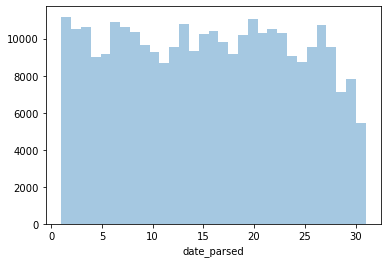

In [21]:
# checking date format
day_of_month = data_dropped['date_parsed'].dt.day
sns.distplot(day_of_month, kde=False, bins=31)
# checked and data is ok

In [9]:
data_dropped.dtypes

summons_number                                int64
plate_id                                     object
registration_state                           object
plate_type                                   object
issue_date                                   object
violation_code                               object
vehicle_body_type                            object
vehicle_make                                 object
issuing_agency                               object
street_code1                                  int64
street_code2                                  int64
street_code3                                  int64
vehicle_expiration_date                       int64
violation_location                           object
violation_precinct                            int64
issuer_precinct                               int64
issuer_code                                   int64
issuer_command                               object
issuer_squad                                 object
violation_ti

In [22]:
usecols = [
    "registration_state", "plate_type", "issue_date", "violation_code", "violation_location", 
    "violation_county", "violation_legal_code", "violation_post_code", "violation_description"
]

data_dropped = data_dropped[usecols]
data_dropped.head()

,registration_state,plate_type,issue_date,violation_code,violation_location,violation_county,violation_legal_code,violation_post_code,violation_description
0,NY,PAS,07/10/2016,7,NaN,BX,T,NaN,FAILURE TO STOP AT RED LIGHT
1,NY,PAS,07/08/2016,7,NaN,BX,T,NaN,FAILURE TO STOP AT RED LIGHT
2,NY,PAS,08/23/2016,5,NaN,BX,T,NaN,BUS LANE VIOLATION
3,NY,COM,06/14/2017,47,0014,NY,NaN,04,47-Double PKG-Midtown
4,NY,COM,11/21/2016,69,0013,NY,NaN,31 6,69-Failure to Disp Muni Recpt


In [23]:
# check inconsistent data entry
data_dropped.registration_state.unique()

data_dropped.plate_type.unique()

data_dropped.violation_location.unique()

# violation_description neeeds to be check
violation_description = data_dropped.violation_description.unique()
violation_description.astype('str').sort()
violation_description

array(['FAILURE TO STOP AT RED LIGHT', 'BUS LANE VIOLATION',
       '47-Double PKG-Midtown', '69-Failure to Disp Muni Recpt', nan,
       'PHTO SCHOOL ZN SPEED VIOLATION', '19-No Stand (bus stop)',
       '71-Insp. Sticker Missing (NYS', '64-No STD Ex Con/DPL, D/S Dec',
       '38-Failure to Display Muni Rec', '71A-Insp Sticker Expired (NYS)',
       '14-No Standing', '75-No Match-Plate/Reg. Sticker',
       '10-No Stopping', '21-No Parking (street clean)', '50-Crosswalk',
       '48-Bike Lane', '68-Not Pkg. Comp. w Psted Sign', '51-Sidewalk',
       '09-Blocking the Box', '37-Expired Muni Meter',
       '16A-No Std (Com Veh) Non-COM', '20A-No Parking (Non-COM)',
       '46A-Double Parking (Non-COM)', '24-No Parking (exc auth veh)',
       '31-No Stand (Com. Mtr. Zone)', '40-Fire Hydrant',
       '13-No Stand (taxi stand)', '46B-Double Parking (Com-100Ft)',
       '16-No Std (Com Veh) Com Plate', '70A-Reg. Sticker Expired (NYS)',
       '42-Exp. Muni-Mtr (Com. Mtr. Z)', '74A-Improperly

In [24]:
# need to substring violation_description because of their contain code in desc that misunderstanding users
# violation_description_fmt = data_dropped['violation_description'].astype('str')
# violation_description_fmt

def extractDesc(row, char):
    splitted = row.split(char)
    if len(splitted) > 1:
        row = splitted[1]
    else:
        row = splitted[0]
    return row

data_dropped['violation_description'] = data_dropped['violation_description'].astype('str').apply(lambda x : extractDesc(x, "-"))


In [25]:
violation_description = data_dropped['violation_description'].unique()
violation_description.sort()
violation_description

array(['Angle PKG', 'Angle PKG ', 'Angle Parking', 'BUS LANE VIOLATION',
       'Beyond Marked Space', 'Bike Lane', 'Blocking Ped. Ramp',
       'Blocking the Box', 'Bus Layover', 'Bus Layover (No Pass)',
       'Bus Layover (W/ Pass)', 'Covered Plate', 'Crosswalk',
       'Detached Trailer', 'Divided Highway', 'Double PKG',
       'Double Parking (Com', 'Double Parking (Com Plate)',
       'Double Parking (Non', 'Downtown Bus Area, No Prmt',
       'Downtown Bus Area, Non', 'Engine Idling',
       'Exc Limit (Com. Mtr. Zone)', 'Excavation (obstruct traff)',
       'Exp. Mtr. (Com. Mtr. Zone)', 'Exp. Muni', 'Expired Muni Meter',
       'FAILURE TO STOP AT RED LIGHT', 'Failure to Disp Muni Recpt',
       'Failure to Display Muni Rec', 'Feeding Meter',
       'Field Release Agreement', 'Fire Hydrant',
       'Improp Safety Stkr (NYS)', 'Improper Registration',
       'Improperly Displayed Plate', 'Impropr Dsply of Reg (NYS)',
       'Insp Sticker Expired (NYS)', 'Insp Stkr Counterfeit',


In [26]:
data_dropped['violation_description'] = data_dropped['violation_description'].str.lower()
data_dropped['violation_description'] = data_dropped['violation_description'].str.strip()

violation_description = data_dropped['violation_description'].unique()
violation_description.sort()
violation_description

array(['angle parking', 'angle pkg', 'beyond marked space', 'bike lane',
       'blocking ped. ramp', 'blocking the box', 'bus lane violation',
       'bus layover', 'bus layover (no pass)', 'bus layover (w/ pass)',
       'covered plate', 'crosswalk', 'detached trailer',
       'divided highway', 'double parking (com',
       'double parking (com plate)', 'double parking (non', 'double pkg',
       'downtown bus area, no prmt', 'downtown bus area, non',
       'engine idling', 'exc limit (com. mtr. zone)',
       'excavation (obstruct traff)', 'exp. mtr. (com. mtr. zone)',
       'exp. muni', 'expired muni meter', 'failure to disp muni recpt',
       'failure to display muni rec', 'failure to stop at red light',
       'feeding meter', 'field release agreement', 'fire hydrant',
       'improp safety stkr (nys)', 'improper registration',
       'improperly displayed plate', 'impropr dsply of reg (nys)',
       'insp sticker expired (nys)', 'insp stkr counterfeit',
       'insp stkr mut

In [39]:

matches = fuzzywuzzy.process.extract("exp. muni", violation_description, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

matches


[('exp. muni', 100),
 ('expired muni meter', 62),
 ('exp. mtr. (com. mtr. zone)', 43),
 ('no parking (exc handicap)', 39),
 ('reg. sticker expired (nys)', 39),
 ('insp sticker expired (nys)', 38),
 ('insp stkr mutilated', 37),
 ('missing equipment (specify)', 36),
 ('bike lane', 35),
 ('failure to disp muni recpt', 35)]

In [33]:
def replace_matches_in_column(df, column, string_to_match, min_ratio):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    print("done")


In [34]:
# angle parking, Selling /Offer Merchandise, exp. muni

replace_matches_in_column(df=data_dropped, column='violation_description', string_to_match="angle parking", min_ratio=80)
replace_matches_in_column(df=data_dropped, column='violation_description', string_to_match="selling /offer merchandise", min_ratio=80)
replace_matches_in_column(df=data_dropped, column='violation_description', string_to_match="exp. muni", min_ratio=60)


done


In [35]:
violation_description = data_dropped['violation_description'].unique()
violation_description.sort()
violation_description

array(['angle parking', 'beyond marked space', 'bike lane',
       'blocking ped. ramp', 'blocking the box', 'bus lane violation',
       'bus layover', 'bus layover (no pass)', 'bus layover (w/ pass)',
       'covered plate', 'crosswalk', 'detached trailer',
       'divided highway', 'double parking (com',
       'double parking (com plate)', 'double parking (non', 'double pkg',
       'downtown bus area, no prmt', 'downtown bus area, non',
       'engine idling', 'exc limit (com. mtr. zone)',
       'excavation (obstruct traff)', 'exp. mtr. (com. mtr. zone)',
       'exp. muni', 'expired muni meter', 'failure to disp muni recpt',
       'failure to display muni rec', 'failure to stop at red light',
       'feeding meter', 'field release agreement', 'fire hydrant',
       'improp safety stkr (nys)', 'improper registration',
       'improperly displayed plate', 'impropr dsply of reg (nys)',
       'insp sticker expired (nys)', 'insp stkr counterfeit',
       'insp stkr mutilated', 'ins